## A simple model for demand and supply of geolocalized services in a city

### Load libraries and classes

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

import os
import sys
nb_dir = os.path.dirname(os.getcwd()) ## TODO: find way to put this into some global settings
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from references import common_cfg, istat_kpi, city_settings

In [2]:
from src.models.city_items import AgeGroup, ServiceArea, ServiceType, SummaryNorm # enum classes for the model
from src.models.core import ServiceUnit, ServiceValues, ServiceEvaluator, \
    MappedPositionsFrame, DemandFrame, KPICalculator
from src.models.factories import UnitFactory
from src.models.process_tools import GridMaker, ValuesPlotter, JSONWriter
from src.models.city_items import get_random_pos

In [3]:
selectedCity = 'Torino'

### Load service data: locations, scales, other info for city

In [4]:
loaders=UnitFactory.make_loaders_for_city(city_settings.get_city_config(selectedCity))
loaders

{'Farmacie': <src.models.factories.PharmacyFactory at 0x7fc99c39f668>,
 'Fermate TPL': <src.models.factories.TransportStopFactory at 0x7fc99c39f4e0>,
 'Scuole': <src.models.factories.SchoolFactory at 0x7fc99c39f5f8>}

In [5]:
# Initialise with a default lengthscale of 0.5 km
schoolUnits = loaders['Scuole'].load(meanRadius=0.5)

# Initialise with a default lengthscale of 0.6 km
pharmacyUnits = loaders['Farmacie'].load(meanRadius=0.5)

# Initialise with a default lengthscale of 0.3 km
## awful hack to quickly clean tpl file #FIXME
loaders['Fermate TPL']._rawData = loaders['Fermate TPL']._rawData[
    loaders['Fermate TPL']._rawData['route_type'].isin([0,1,3])].reset_index()

tplUnits = loaders['Fermate TPL'].load(meanRadius=0.3)
tplUnits = []
# Initialise with a default lengthscale of 0.5 km
#libraryUnits = bibliotecheLoader.load(meanRadius=0.8)

Location data found
Location data found
Location data found


### Demand import from Censimento Popolazione e Abitazioni (CPA) 2011

In [6]:
demandData = DemandFrame.create_from_istat_cpa(selectedCity)

bDemo = False
if bDemo:
    # demo mode, use a portion of the data
    demandTest = DemandFrame(demandData.sample(50).copy(), False)
    testUnits = schoolUnits[::50] + pharmacyUnits[::30] + tplUnits[::30] 
    calculator = KPICalculator(demandTest, testUnits, selectedCity)
else:
    calculator = KPICalculator(demandData, schoolUnits + pharmacyUnits + tplUnits, selectedCity)

### Evaluate the services offer at the demand points and average over neighbourhood

In [7]:
# compute and plot demand/supply interaction for localized services 
calculator.evaluate_services_at_demand(bEvaluateAttendance=True)  # this might take a while.
calculator.compute_kpi_for_localized_services()
pass

ServiceType.Pharmacy Approx distance matrix in 0.0133

 Computing ServiceType.Pharmacy AgeGroup.Newborn
AgeGroup time 3.3488

 Computing ServiceType.Pharmacy AgeGroup.Kinder
AgeGroup time 0.9988

 Computing ServiceType.Pharmacy AgeGroup.ChildPrimary
AgeGroup time 0.9867

 Computing ServiceType.Pharmacy AgeGroup.ChildMid
AgeGroup time 1.0280

 Computing ServiceType.Pharmacy AgeGroup.ChildHigh
AgeGroup time 1.0974

 Computing ServiceType.Pharmacy AgeGroup.Young
AgeGroup time 0.9956

 Computing ServiceType.Pharmacy AgeGroup.Junior
AgeGroup time 1.0089

 Computing ServiceType.Pharmacy AgeGroup.Senior
AgeGroup time 0.9747

 Computing ServiceType.Pharmacy AgeGroup.Over50
AgeGroup time 0.9715

 Computing ServiceType.Pharmacy AgeGroup.Over65
AgeGroup time 0.9702

 Computing ServiceType.Pharmacy AgeGroup.Over74
AgeGroup time 1.0341
ServiceType.School Approx distance matrix in 0.0085

 Computing ServiceType.School AgeGroup.ChildPrimary
AgeGroup time 2.3939

 Computing ServiceType.School AgeGroup

In [8]:
pharma = calculator.evaluator.unitsTree[ServiceType.Pharmacy]
argh = [p for p in pharma if p.attendance >5000]

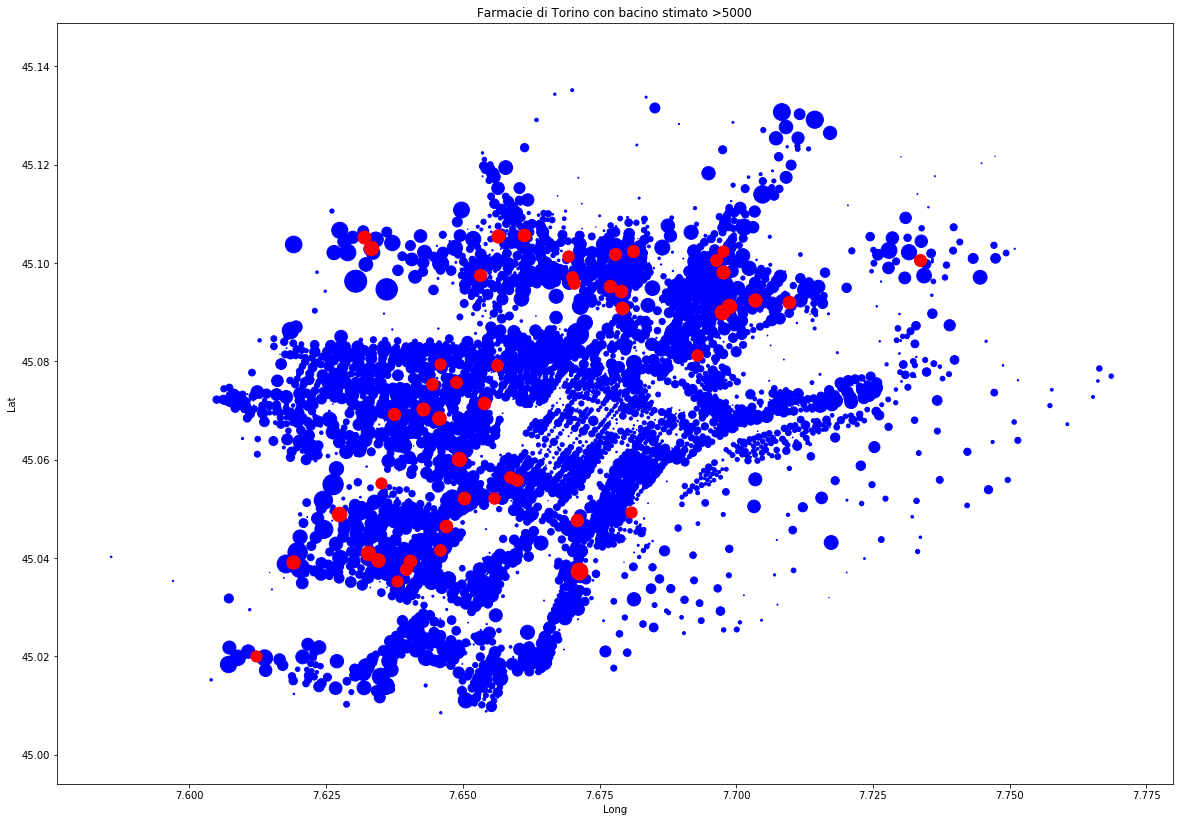

In [11]:
plt.scatter(demandData.mappedPositions.Long,demandData.mappedPositions.Lat, c='b',s=demandData.P1, marker='.')
for a in argh: 
    plt.scatter(a.site.longitude, a.site.latitude, c='red',marker='.',s=a.attendance/10)
if not argh: print('ALL FINE!')
plt.xlabel('Long')
plt.ylabel('Lat')
plt.title('Farmacie di %s con bacino stimato >5000' % selectedCity)
plt.show()

In [ ]:
for sType, units in calculator.evaluator.unitsTree.items():
    values = [u.attendance for u in units]
    print(min(values), max(values))
    sns.distplot(values, 80)
    plt.title(sType)
    plt.show()
    

### Append Istat KPI and export averaged values by Neighbourhood-Service-AgeGroup to JSON

In [ ]:
# compute istat kpi as well
calculator.compute_kpi_for_istat_values()

# write KPI to json outputb
jsonMaker = JSONWriter(calculator)
jsonMaker.write_all_files_to_default_path()

In [ ]:
bSavePickle = False
import pickle
import time
filename = './pickles/'+ selectedCity + '_%i.pickle' % int(time.time())
if bSavePickle:
    with open(filename, 'wb') as f:
        pickle.dump(calculator, f)